In [1]:
%pip install keras_self_attention
%pip install keras-tuner

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=798e7d89191aa9c43156b3ec10ef3a9f073251f5bbdc0fe7b34d9b3407980fb7
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention
     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=e71c0d3f9c5db49d6b08c626d231ba30db26b394becb9be9491f0771df529655
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=fab1989ac37959504afaf1b59d73ef10058658a7d0d226e9b4e3d632ef172ef8
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU, Dropout, Bidirectional, Flatten
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import numpy as np
import matplotlib
import os

In [3]:
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kerastuner as kt
from kerastuner import HyperModel
import numpy as np
import itertools
import multiprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LeakyReLU, Dropout, Input, InputLayer, GRU, GaussianNoise
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import numpy as np
import matplotlib
import os
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [5]:
def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")


def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

# data extraction
def getData(is500=True, shuffle=False, ise2e=False, include_secondary=False, validation_split=None, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Train_Data" if ise2e else "Fold_10_Train_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Test_Data" if ise2e else "Fold_10_Test_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    X_validation = Y_validation = None
    if validation_split is not None:
        # sklearn split shuffles anyway
        X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_split)

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eData(is500=True, shuffle=False, include_secondary=False, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Data_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Secondary_Data_1136.h5', 'r') if include_secondary else h5.File(
        f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


In [6]:
def reverse_one_hot(Y_input):
    return np.apply_along_axis(np.argmax, 1, Y_input) + 1

def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()


def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_and_fit_model(model_func,
                          model_name,
                          input_shape,
                          X_train,
                          Y_train,
                          save_every_epoch=True,
                          save_final=False,
                          **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_every_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m


def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def get_combined_features_from_models(
        to_combine,
        X_train, Y_train,
        X_test, Y_test,
        reverse_one_hot=False,
        normalize_X_func=None):
    
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    models_have_different_inputs = isinstance(Y_train,list)

    if reverse_one_hot:
        if models_have_different_inputs:
            Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1
            Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1
        else:
            Y_train_new = [ np.apply_along_axis(np.argmax, 1, y_train) + 1 for y_train in Y_train ]  
            Y_test_new = [ np.apply_along_axis(np.argmax, 1, y_test) + 1 for y_test in Y_test ]              
    else:
        if models_have_different_inputs:
            Y_train_new = Y_train.copy()
            Y_test_new = Y_test.copy()
        else:
            Y_train_new = [ y_train.copy() for y_train in Y_train ] 
            Y_test_new = [ y_test.copy() for y_test in Y_train ] 
            

    extraction_counter =0
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter]), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter]), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter])), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter])), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here
        extraction_counter += 1

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)

    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)

    return models, data_train, data_test, XY_dict


def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer
    
            old_weights, old_biases = model.layers[ix].get_weights()
    
            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])            
    return model

def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32),(0,)) )

   
def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep    





In [7]:
def model_with_pure_rnn(model_name, input_shape):
    
    #RNN part
    inputs = Input(shape=input_shape)
    lstm_one = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(inputs)
    #lstm_one = Dropout(0.3)(lstm_one)
    #lstm_one = GaussianNoise(0.05)(lstm_one)
    lstm_two = Bidirectional(GRU(128, return_sequences=True, kernel_initializer='RandomNormal', dropout= 0.5, recurrent_dropout = 0.5, recurrent_initializer='RandomNormal', bias_initializer='zero'))(lstm_one)
    #lstm_two = Dropout(0.3)(lstm_two)
    #lstm_two = GaussianNoise(0.05)(lstm_two)
    attention = SeqWeightedAttention()(lstm_two)
    #attention_mul = attention_3d_block(lstm_two)
    attention = Flatten()(attention)
    rnnoutput = Dense(256,kernel_initializer='RandomNormal', bias_initializer='zeros')(attention)
    rnnoutput = BatchNormalization()(rnnoutput)
    rnnoutput = GaussianNoise(1)(rnnoutput)
    rnnoutput = Dropout(0.4)(rnnoutput)

    #Dense Feed-forward
    dense_one = Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros')(rnnoutput)
    dense_one = LeakyReLU()(dense_one)
    dense_one = Dropout(0.5)(dense_one)
    dense_one = BatchNormalization()(dense_one)
    dense_two = Dense(64, kernel_initializer='RandomNormal', bias_initializer='zeros')(dense_one)
    dense_two = LeakyReLU()(dense_two)
    dense_two = Dropout(0.4)(dense_two)

    #Output
    output = Dense(13, activation='softmax')(dense_two)
    model = Model([inputs], output, name=model_name)
    return model

In [8]:
# 'new' data 
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData(is500=False,
                                                                                                    include_secondary=False,
                                                                                                    isColab=True)
X_train_1000e_w2nd, Y_train_1000e_w2nd, X_test_1000e_w2nd, Y_test_1000e_w2nd, X_val_1000e_w2nd, Y_val_1000e_w2nd = getE2eData(is500=False, include_secondary=True, isColab=True)
X_train_1000e_j2nd, Y_train_1000e_j2nd, X_test_1000e_j2nd, Y_test_1000e_j2nd, X_val_1000e_j2nd, Y_val_1000e_j2nd = getE2eDataJustSecondary(isColab=True)

In [9]:
print (X_train_1000e.shape)
print (X_train_1000e_w2nd.shape)
print (X_train_1000e_j2nd.shape)

(6858, 1000, 8)
(6858, 1136, 12)
(6858, 1000, 3)


In [10]:
# merge into a new train:
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )    

X_new_train_j2nd = np.concatenate( (X_train_1000e_j2nd, X_val_1000e_j2nd), axis=0 )
Y_new_train_j2nd = np.concatenate( (Y_train_1000e_j2nd, Y_val_1000e_j2nd), axis=0 )    

X_new_train_w2nd = np.concatenate( (X_train_1000e_w2nd, X_val_1000e_w2nd), axis=0 )
Y_new_train_w2nd = np.concatenate( (Y_train_1000e_w2nd, Y_val_1000e_w2nd), axis=0 )    


In [11]:
# CNNs no secondary
mCNN1_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e1000_256.h5") # CNN on 256 1st dens
mCNN1_1000._name = "cnn_merged_newdata_finalist_1"

mCNN2_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e.h5")   # CNN on 128 1st dens
mCNN2_1000._name = "cnn_merged_newdata_finalist_2"

mCNN_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/cnn_noTest_20210516_model_445_0.998")   # CNN on 128 1st dens
mCNN_1000._name = "cnn_merged_newdata_colab_finalist"

mCNN_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/cnn_noTest_20210516_model_445_0.998")   # CNN on 128 1st dens
mCNN_1000._name = "cnn_merged_newdata_colab_finalist"

# CNN w/ secondary
mCNN_1000_w2nd = load_model("./drive/MyDrive/data_papers/ncRNA/CNN_baseline_May16_e2e_secondary.h5", custom_objects=SeqWeightedAttention.get_custom_objects())
mCNN_1000_w2nd._name = "cnn_merged_newdata_w_secondary_finalist"

# CNN secondary only
mCNN_1000_j2nd = load_model("./drive/MyDrive/data_papers/ncRNA/cnn_j2nd_noTest_20210516_model_488_0.990", custom_objects=SeqWeightedAttention.get_custom_objects())
mCNN_1000_j2nd._name = "cnn_merged_newdata_j_secondary_finalist"

# RNN on the e2e data
RNN_1000 = load_model("./drive/MyDrive/data_papers/ncRNA/RNN_baseline_17May_180.h5", custom_objects=SeqWeightedAttention.get_custom_objects())   # RNN on 180ep 1000 ts
RNN_1000._name = "rnn_merged_newdata_colab_finalist"

# RNN with secondary still needs to continue fit ## requires the validation in the fit data!
RNN_1000_w2nd = load_model("./drive/MyDrive/data_papers/ncRNA/rnn_merged_newdata_w2nd_colab_continue_fit_epoch_96_accuracy_0.948.h5", custom_objects=SeqWeightedAttention.get_custom_objects())   # RNN on 180ep 1000 ts
RNN_1000_w2nd._name = "rnn_newdata_w2nd_colab_continue_fit"

# RNN on the e2e data just secondary
RNN_1000_j2nd = load_model("./drive/MyDrive/data_papers/ncRNA/rnn_newdata_j2nd_colab_continue_fit_epoch_33_accuracy_0.621.h5", custom_objects=SeqWeightedAttention.get_custom_objects())   # RNN on 180ep 1000 ts
RNN_1000_j2nd._name = "rnn_newdata_j2nd_colab_continue_fit"


mCNN1_1000.evaluate(X_test_1000e, Y_test_1000e)  # 96.15% 
mCNN2_1000.evaluate(X_test_1000e, Y_test_1000e)  # 95.80 %  
mCNN_1000.evaluate(X_test_1000e, Y_test_1000e)  # 95.57% 
mCNN_1000_w2nd.evaluate(X_test_1000e_w2nd, Y_test_1000e_w2nd)  # 94.64 %
mCNN_1000_j2nd.evaluate(X_test_1000e_j2nd, Y_test_1000e_j2nd)  # 72.96 %
RNN_1000.evaluate(X_test_1000e, Y_test_1000e)  # 95.45 %
RNN_1000_w2nd.evaluate(X_test_1000e_w2nd, Y_test_1000e_w2nd)  # 91.72 %
RNN_1000_j2nd.evaluate(X_test_1000e_j2nd, Y_test_1000e_j2nd)  # 54.31 %



27/27 [==============================] - 33s 1s/step - loss: 1.4324 - accuracy: 0.5431


[1.4324291944503784, 0.5431235432624817]

In [12]:
class SaveBestOverCombinedThresholds(tf.keras.callbacks.Callback):
    def __init__(self, colab_download = False, observed_values = [ ('accuracy',0.9) ] ):
        self.thresholds = dict(observed_values)
        self.last_best_values = dict([ (obs_name, np.nan) for obs_name in self.thresholds.keys()] )
        self.colab_download = colab_download
        
    def on_epoch_end(self, epoch, logs=None):        
        register = None
        for k,v in self.thresholds.items():
            if k not in logs.keys():
                raise ValueError(f"{k} not found in logs")
            passes_threshold = logs[k] > self.thresholds[k]                 
            register = passes_threshold if register is None else (register and passes_threshold)
        
        if register:
            for k,v in self.thresholds.items():
                if np.isnan(self.last_best_values[k]):
                    self.last_best_values[k] = logs[k]
                else:
                    if logs[k] < self.last_best_values[k]:
                        register = False
                        break
            if register:
                for k,v in self.thresholds.items():
                    self.last_best_values[k] = logs[k]

                if self.colab_download:
                    base_name = f'{self.model.name}_epoch_{str(epoch)}_{"_".join(["{}_{:.3f}".format(k,v) for k,v in self.last_best_values.items()])}'
                    self.model.save(f'/drive/MyDrive/data_papers/ncRNA/{base_name}.h5')                
                    history_df = pd.DataFrame(self.model.history.history) 
                    history_df.to_csv(f'/drive/MyDrive/data_papers/ncRNA/{base_name}_history.csv',header=True, index=False)
                    # from google.colab import files
                    # files.download(f'/drive/MyDrive/data_papers/ncRNA/{base_name}.h5')
                    # files.download(f'/drive/MyDrive/data_papers/ncRNA/{base_name}_history.csv')
                else:
                    base_name = f'{self.model.name}_epoch_{str(epoch)}_{"_".join(["{}_{:.3f}".format(k,v) for k,v in self.last_best_values.items()])}'
                    self.model.save(f'{base_name}.h5')                
                    history_df = pd.DataFrame(self.model.history.history) 
                    history_df.to_csv(f'{base_name}_history.csv',header=True, index=False)

In [13]:
X_train_1000e_w2nd[0].shape
X_val_1000e_w2nd.shape

(857, 1136, 12)

In [ ]:
# mRNNpure_w2nd = model_with_pure_rnn("rnn_w2nd_continue", input_shape=X_train_1000e_w2nd[0].shape)
mRNNpure_w2nd = RNN_1000_w2nd # tf.keras.models.clone_model(RNN_1000_w2nd)

callbacks_used_rnn_w2nd = [SaveBestOverCombinedThresholds(colab_download=False, observed_values=[('accuracy',0.2)]), tf.keras.callbacks.EarlyStopping(patience=40)]
mRNNpure_w2nd.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
historyRNN = mRNNpure_w2nd.fit(X_train_1000e_w2nd, 
                          Y_train_1000e_w2nd, 
                          batch_size=128, 
                          epochs= 150, 
                          callbacks=callbacks_used_rnn_w2nd, 
                          verbose=2, 
                          class_weight= None, 
                          validation_data=(X_val_1000e_w2nd, Y_val_1000e_w2nd)) 
mRNNpure_w2nd.save(f"{mRNNpure_w2nd.name}.h5") #Save the model
mRNNpure_w2nd.evaluate(X_test_1000e_w2nd, Y_test_1000e_w2nd)

Epoch 1/150
54/54 - 740s - loss: 0.1829 - accuracy: 0.9440 - val_loss: 0.4497 - val_accuracy: 0.9020
Epoch 2/150
54/54 - 728s - loss: 0.1736 - accuracy: 0.9424 - val_loss: 0.4322 - val_accuracy: 0.9055
Epoch 3/150
54/54 - 722s - loss: 0.1608 - accuracy: 0.9498 - val_loss: 0.4243 - val_accuracy: 0.9113
Epoch 4/150
54/54 - 725s - loss: 0.1570 - accuracy: 0.9497 - val_loss: 0.4098 - val_accuracy: 0.9102
Epoch 5/150
54/54 - 716s - loss: 0.1745 - accuracy: 0.9459 - val_loss: 0.4071 - val_accuracy: 0.9102
Epoch 6/150
54/54 - 724s - loss: 0.1553 - accuracy: 0.9503 - val_loss: 0.3976 - val_accuracy: 0.9148
Epoch 7/150
54/54 - 725s - loss: 0.1651 - accuracy: 0.9469 - val_loss: 0.3900 - val_accuracy: 0.9055
Epoch 8/150
54/54 - 725s - loss: 0.1521 - accuracy: 0.9500 - val_loss: 0.4501 - val_accuracy: 0.9032
Epoch 9/150
54/54 - 727s - loss: 0.1551 - accuracy: 0.9503 - val_loss: 0.3445 - val_accuracy: 0.9207
Epoch 10/150
54/54 - 752s - loss: 0.1560 - accuracy: 0.9519 - val_loss: 0.4435 - val_accura

In [ ]:
mRNNpure = model_with_pure_rnn("rnn_with_w2nd", input_shape=X_train_1000e_w2nd[0].shape)
callbacks_used_rnn_combine_w2nd = [ModelCheckpoint(f'{mRNNpure.name}' + '_model_{epoch:03d}_Acc_{accuracy:0.3f}_valAcc_{val_accuracy:0.3f}',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True),
                    tf.keras.callbacks.EarlyStopping(patience=10)
                    ]
mRNNpure.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
historyRNN = mRNNpure.fit(X_train_1000e_w2nd, 
                          Y_train_1000e_w2nd, 
                          batch_size=128, 
                          epochs= 30, 
                          callbacks=callbacks_used_rnn_combine_w2nd, 
                          verbose=2, 
                          class_weight= None, 
                          validation_data=(X_val_1000e_w2nd, Y_val_1000e_w2nd)) # Train 50 epochs
mRNNpure.save(f"{mRNNpure.name}.h5") #Save the model

In [ ]:
historyRNN2 = mRNNpure.fit(X_train_1000e_w2nd, 
                          Y_train_1000e_w2nd, 
                          batch_size=128, 
                          epochs= 150, 
                          callbacks=callbacks_used_rnn_combine_w2nd, 
                          verbose=2, 
                          class_weight= None, 
                          validation_data=(X_val_1000e_w2nd, Y_val_1000e_w2nd)) # Train 50 epochs
mRNNpure.save(f"{mRNNpure.name}_2.h5") #Save the model

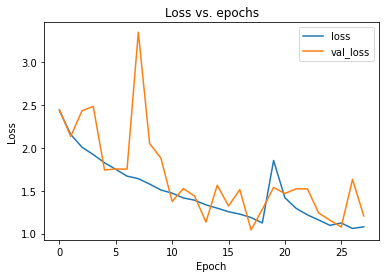

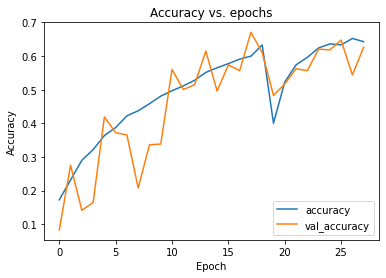

In [ ]:
 plot_history(historyRNN)
 #tf.keras.utils.plot_model(RNN_1000, show_shapes=True)  ## , to_file="C:/temp/test.png")

In [ ]:
# cnn_combine_model.save("merge_model_a.h5")
# rcnn_combine_model.save("merge_model_b.h5")
# cnn_penul_combine_model.save("merge_model_c.h5")
# rcnn_penul_combine_model.save("merge_model_d.h5")
# rcnn_combine_models_no2nd_rNo2nd.save("merge_model_e.h5")
# rcnn_combine_penul_models_no2nd_rNo2nd.save("merge_model_f.h5")
# rcnn_last2_combine_model_no2nd_rNo2nd.save("merge_model_g.h5")
# rcnn_last2_combine_model_no2nd_j2nd_rNo2nd.save("merge_model_h.h5")

In [ ]:
from google.colab import files
# files.download("/content/merge_model_a.h5")
# files.download("/content/merge_model_b.h5")
# files.download("/content/merge_model_c.h5")
# files.download("/content/merge_model_d.h5")
# files.download("/content/merge_model_e.h5")
# files.download("/content/merge_model_f.h5")
# files.download("/content/merge_model_g.h5")
# files.download("/content/merge_model_h.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>